<a href="https://colab.research.google.com/github/martingrzzler/colab-notebooks/blob/master/deep_learning_foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('sample_data/mnist_train_small.csv')
test_data = pd.read_csv('sample_data/mnist_test.csv')

In [3]:
data_np = data.to_numpy()
test_data_np = test_data.to_numpy()
data_np.shape, test_data_np.shape

((19999, 785), (9999, 785))

In [4]:
Y = data_np[:,0]
X = data_np[:,1:]
Y_test = test_data_np[:,0]
X_test = test_data_np[:,1:]
N = X.shape[0]

In [5]:
dims = np.sqrt(X[0].shape[0]).astype(int)

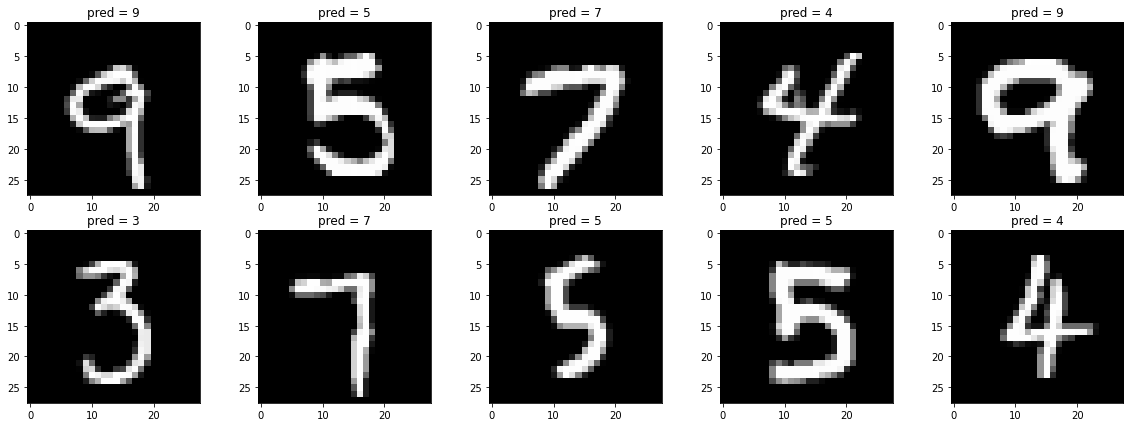

In [6]:
fig, axs = plt.subplots(2,5,figsize=(20,7))
for ax in axs.flat:
  index = np.random.randint(0, N)
  img = X[index].reshape((dims,dims))
  ax.set_title(f"pred = {Y[index]}")
  ax.imshow(img, cmap='gray', vmin=0, vmax=255)


(array([1962., 2243., 1989., 2021., 1924., 1761., 2038., 2126., 1912.,
        2023.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

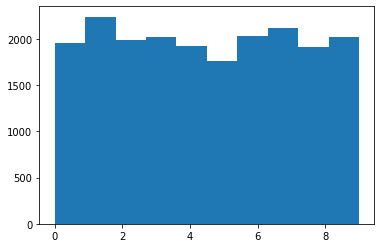

In [7]:
plt.hist(Y, bins=10)
# evenly distributed

In [8]:
X_norm = X / np.max(X)
X_test_norm = X_test / np.max(X_test)

Now that I have labels and training data let's build the Neural Network.

### Cost function and Gradient Descent

This is a categorical problem so I will use the `Cross Entropy Function`. Why choosing any particular cost function? Minimizing the cost is the same as finding a solution to a maximum likelihood problem. The likelihood tells us how likely it is that the data can be modeled by a particular distribution with certain parameters. Depending on what parameters one uses this liklihood will be bigger or smaller. In practice the likelyhood is the product over all datapoint's PDF function: $\prod_{i=1}^{N} PDF(x_i; w)$. In the case of a categorical distribution it is $\prod_{n=1}^{N}\prod_{k=1}^K p_k^{[t_n=k]}$. This is often transformed to the log likelihood which makes taking the derivative easier and numbers more stable as a product of probabilities becomes very small very fast.

$\sum_{n=1}^{N}\sum_{k=1}^K [t_n=k] \log(p_k)$

Now imagine the $p_k$ to be the probability the model predicts. If it predicts one for the correct target it outputs zero. If it predicts 0.5 for the correct target the win will be $1 \log(0.5) = -0.693$. So as the prediciton goes more wrong the win drops as well. Notice in order to turn this into a loss function rather than "win" function, simply add a negative sign. In that case 0.6 will mean a higher loss than 0. Without the negative sigm one must go uphill when doing gradient descent.

### Architecure

<img width="300" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/basic-nn.png" />

#### Definitions
$D=784$ - number of input features

$M=16$ - number of hidden layer nodes

$K=10$ - number of output nodes

Forward pass:

$α=W^Tx+b$

$z=σ(α)$

$a=V^Tz+c$

$y=softmax(a)$

$J=\sum_{n=1}^N\sum_{k=1}^Kt_{nk}log(y_{nk})$ - the loss function
#### Derivatives
_Softmax_:


$\frac{δJ}{δa_{nk}}=∑^N_{n=1}∑_{k'=1}^K\frac{δJ}{δy_{nk'}}\frac{δy_{nk'}}{δa_{nk}}$

$\frac{δJ}{δa_{nk}}=y_{nk'}(𝛅-y_{nk})$

$𝜹=\binom{k'=k→1}{k'!=k→0}$

<img width="500" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/softmax_derivative.jpg" />

_Cross Entropy Loss_:

$\frac{δJ}{δy_{nk'}}=\frac{t_{nk'}}{y_{nk'}}$

Bringing them together:

$\sum_{n=1}^N\sum_{k'=1}^Kt_{nk'}(𝛅_{kk'}-y_nk)$

split the sum

1. $\sum_{k'=1}^Kt_{k'}𝛅_{kk'}=t_k$ because $t_k*1 + 0 = t_k$


2. $\sum_{k'=1}^Kt_{k'}y_{k}=y_k\sum_{k'=1}^Kt_k'=y_k*1=y_k$


$\sum_{n=1}^N(t_{nk}-y_{nk})$

$𝚫J=X^T(T-Y)$


_Sigmoid_:

<img width="250" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/sigmoid_derivative.jpg" />

so the derivatives for $c,V,b,W$:

$δJ/δV_{nk}=\sum_{n=1}^N(t_{nk}-y_{nk})z_{nm}$

$δJ/δc_{nk}=\sum_{n=1}^N(t_{nk}-y_{nk})$

$δJ/δW_{dm}=\sum_{n=1}^N\sum_{k=1}^K(t_{nk}-y_{nk})V_{mk}z_{nm}(1-z_{nm})x_{nd}$

$δJ/δb_{dm}=\sum_{n=1}^N\sum_{k=1}^K(t_{nk}-y_{nk})V_{mk}z_{nm}(1-z_{nm})$






In [9]:
def get_win(T, Y):
  tot = T * np.log(Y)
  return tot.sum()

def forward(X, W, b, V, c):
  Z = 1 / (1 + np.exp(-X.dot(W) - b))
  A = Z.dot(V) + c
  expA = np.exp(A)
  Y = expA / expA.sum(axis=1, keepdims=True)
  return Y, Z

def derivative_V(Z, T, Y):
  return Z.T.dot(T - Y)

def derivative_c(T, Y):
  return (T - Y).sum(axis=0)

def derivative_W(X, Z, T, Y, V):
    dZ = (T - Y).dot(V.T) * Z * (1 - Z)
    return X.T.dot(dZ)

def derivative_b(T, Y, V, Z):
    return ((T - Y).dot(V.T) * Z * (1 - Z)).sum(axis=0)

def accuracy(Y, P):
  return np.mean(Y==P)


def to_indicator(Y, K):
  T = np.zeros((len(Y),K))
  for n in range(len(Y)):
    T[n,Y[n]] = 1
  return T


epoch: 0 win: -115747.05907377148 accuracy: 0.09580479023951198
epoch: 20 win: -41608.79465961439 accuracy: 0.20611030551527576
epoch: 40 win: -30663.132178566644 accuracy: 0.46782339116955846
epoch: 60 win: -27985.997830196266 accuracy: 0.5305765288264414
epoch: 80 win: -27493.029659638516 accuracy: 0.5493774688734436
epoch: 100 win: -24974.28463368691 accuracy: 0.5931796589829491
epoch: 120 win: -24489.20004426909 accuracy: 0.6125306265313266
epoch: 140 win: -24662.817809414773 accuracy: 0.608580429021451
test accuracy: 0.6401640164016401


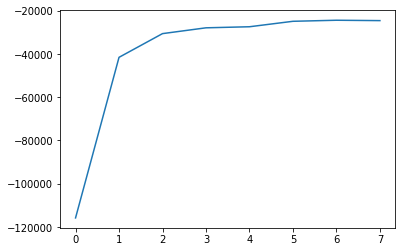

In [10]:
D = X[0].shape[0]
M = 16
K = 10
T = to_indicator(Y, K)

# initialize weights
W = np.random.randn(D, M)
b = np.zeros(M)
V = np.random.randn(M, K)
c = np.zeros(K)

learning_rate = 0.001
costs = []

for epoch in range(150):
  output, hidden = forward(X_norm, W, b, V, c)

  if epoch % 20 == 0:
    win = get_win(T, output)
    P = np.argmax(output, axis=1)
    print("epoch:", epoch, "win:", win, "accuracy:", accuracy(Y,P))
    costs.append(win)

  gV = derivative_V(hidden,T, output)  
  gc = derivative_c(T,output)  
  gW = derivative_W(X_norm,hidden,T,output,V) 
  gb = derivative_b(T, output, V, hidden)  

  V += learning_rate * gV
  c += learning_rate * gc
  W += learning_rate * gW
  b += learning_rate * gb

# test accuracy
P_test_proba, _ = forward(X_test_norm, W, b, V, c)
P_test = np.argmax(P_test_proba, axis=1)
print("test accuracy:", accuracy(Y_test, P_test))

plt.plot(costs)
plt.show()

### Generalizing to arbitrary layer size

<div>
  <img width="400" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/two-hidden-layer.png" />
  <img width="400" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/three-layer-functions.png" />
</div>

<img width="700" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/first-layer-derivative.png" />

Consider one weight $W_{dm^{(1)}}^{(1)}$, so connecting the input layer to the first hidden layer. This directly only influences the current $a_{nm^{(1)}}^{(1)}$. In turn this only influences the activation $z_{nm^{(1)}}^{(1)}$. Now however all $a_{nm^{(2)}}^{(2)}$ are directly influenced. Realize that a tiny change in the first layer influences everything that comes after.

_The derivatives_

<img width="700" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/three-derivatives.png" />

_The following pattern emerges_:

$𝜟_{W^{(l)}}J=Z^{(l-1)T}𝛅^{(l)}$

For any weight matrix $W^{(l)}$ it't gradient is the input into the current layer times some $𝛅$.

_Equations to implement_:

<img width="500" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/grad-update.png" />

<img width="500" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/delta-update.png" />

In [11]:
def sigmoid(A):
  return 1.0 / (1.0 + np.exp(-A))

def softmax(A):
  expA = np.exp(A)
  return expA / np.sum(expA, axis=1, keepdims=True)

def derivative_sigmoid(X):
  sig = sigmoid(X)
  return (1.0 - sig) * sig

def get_cost(T, Y):
  tot = T * np.log(Y)
  return -tot.mean()

def forward_hidden(X, W, b):
    return sigmoid(X.dot(W) + b)
  
def forward_output(X, W, b):
    return softmax(X.dot(W) + b)


epoch: 0 cost: 0.40243192449941667 accuracy: 0.09425471273563678
epoch: 10 cost: 0.14630711133219784 accuracy: 0.52067603380169
epoch: 20 cost: 0.10999041288764592 accuracy: 0.6425821291064553
epoch: 30 cost: 0.09504997481122429 accuracy: 0.6966848342417121
epoch: 40 cost: 0.08678297273894085 accuracy: 0.7282864143207161
epoch: 50 cost: 0.08170780902045068 accuracy: 0.7488874443722187
epoch: 60 cost: 0.0780853893383041 accuracy: 0.7626381319065954
epoch: 70 cost: 0.07513766248781178 accuracy: 0.7732386619330966
epoch: 80 cost: 0.07268693295072143 accuracy: 0.7788889444472223
epoch: 90 cost: 0.0705049790992115 accuracy: 0.7860393019650983


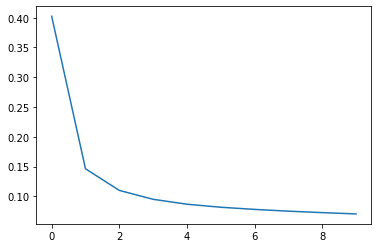

In [12]:
D = X[0].shape[0]
M = 16
K = 10

num_layers = 3
L = num_layers - 1

# initialize weights

W = [np.random.randn(M,M) for i in range(L - 2)]
W.insert(0,np.random.randn(D,M))
W.append(np.random.randn(M,K))

b = [np.zeros((M)) for i in range(L - 1)]
b.append(np.zeros(K))

T = to_indicator(Y, K)

learning_rate = 0.0001
costs = []

Z = [0 for i in range(L)]
 
# Note - for a 4 layer network we have 3 W's, 3 b's and 3 Z's

for epoch in range(100):
  # forward pass
  Z[0] = forward_hidden(X_norm, W[0], b[0])
  for i in range(1, L - 1):
    Z[i] = forward_hidden(Z[i - 1], W[i], b[i])
  Z[-1] = forward_output(Z[-2], W[-1], b[-1])
  output = Z[-1]

  if epoch % 10 == 0:
    cost = get_cost(T, output)
    P = np.argmax(output, axis=1)
    print("epoch:", epoch, "cost:", cost, "accuracy:", accuracy(Y,P))
    costs.append(cost)

  # when doing gradient descent it's output - T
  delta = output - T
  gradW = Z[-2].T.dot(delta)
  gradb = np.sum(delta, axis=0)


  W[-1] -= learning_rate * gradW
  b[-1] -= learning_rate * gradb

  for j in reversed(range(1, L - 1)):
    delta = delta.dot(W[j+1].T) * derivative_sigmoid(Z[j])
    gradW = Z[j-1].T.dot(delta)
    gradb = np.sum(delta, axis=0)
    W[j] -= learning_rate * gradW
    b[j] -= learning_rate * gradb
  
  delta = delta.dot(W[1].T) * derivative_sigmoid(Z[0])
  gradW = X_norm.T.dot(delta)
  gradb = np.sum(delta, axis=0)
  W[0] -= learning_rate * gradW
  b[0] -= learning_rate * gradb

plt.plot(costs)
plt.show()

In [13]:
from typing import List

class Math:
  @staticmethod
  def softmax(A):
    expA = np.exp(A)
    return expA / np.sum(expA, axis=1, keepdims=True)

  @staticmethod
  def accuracy(Y, P):
    return np.mean(Y==P)

class Sigmoid:
  def __call__(self, A):
    return 1.0 / (1.0 + np.exp(-A))
  
  def derivative(self, X):
    sig = sigmoid(X)
    return (1.0 - sig) * sig

class ReLU:
  def __call__(self, A):
    copy = np.copy(A)
    copy[A < 0] = 0
    return copy

  def derivative(self, X):
    return (X > 0).astype(np.float64)


 

class ANN:
  def __init__(self, layers: List[int], learning_rate=0.0001, epochs=300, batch_size=256, verbose=True, activation=Sigmoid):
    # common init for ReLU
    self.W = [np.random.randn(layers[i],layers[i+1]) * np.sqrt(2/layers[i]) for i in range(len(layers) - 1)]
    self.b = [np.zeros(layers[i]) for i in range(1,len(layers))]
    self.activation = activation()
    self.layers = layers
    self.costs = []
    self.epochs = epochs
    self.lr = learning_rate
    self.batch_size = batch_size
    self.verbose = verbose

  def fit(self, X, Y):
    # drops the last batch
    batches = X.shape[0] // self.batch_size

    for e in range(self.epochs):
      X_shuffle, Y_shuffle = self.__unison_shuffle(X,Y)

      for b in range(batches):
        X_batch = X_shuffle[b*self.batch_size:(b*self.batch_size + self.batch_size),:]
        Y_batch = Y_shuffle[b*self.batch_size:(b*self.batch_size + self.batch_size)]
        T = self.__Y_to_indicator(Y_batch)
      
        Z = self.__forward(X_batch)
        cost = self.__get_cost(T, Z[-1])
        self.costs.append(cost)
        
        if self.verbose and b == 0:
          self.__log(Y_batch, e, cost, Z[-1])

        self.__backprop(T, Z, X_batch)
    
    return self.costs

  def predict(self, X):
    Z = self.__forward(X)
    return np.argmax(Z[-1], axis=1)

  def __log(self, Y, e, cost, P_proba):
        print(f"Epoch: {e}, Cost: {cost:.3f}, Accuracy: {Math.accuracy(Y, np.argmax(P_proba, axis=1)):.2f}")

  def __backprop(self, T, Z, X):
    delta = Z[-1] - T 
    gradW = Z[-2].T.dot(delta) / self.batch_size
    gradb = np.sum(delta, axis=0) / self.batch_size

    self.W[-1] -= self.lr * gradW
    self.b[-1] -= self.lr * gradb

    for j in reversed(range(0, len(self.layers) - 2)):
      delta = delta.dot(self.W[j+1].T) * self.activation.derivative(Z[j])
      gradW =  Z[j-1].T.dot(delta) if j > 0 else X.T.dot(delta)
      gradb = np.sum(delta, axis=0)
      self.W[j] -= self.lr * gradW / self.batch_size
      self.b[j] -= self.lr * gradb / self.batch_size
  

  def __forward(self, X):
    Z = [0 for i in range(len(self.layers)-1)]
    Z[0] = self.activation(X.dot(self.W[0]) + self.b[0])
    for i in range(1,len(Z) - 1):
      Z[i] = self.activation(Z[i-1].dot(self.W[i]) + self.b[i])
    Z[-1] = Math.softmax(Z[-2].dot(self.W[-1]) + self.b[-1])

    return Z

  def __Y_to_indicator(self, Y):
    K = self.layers[-1]
    T = np.zeros((len(Y),K))
    for n in range(len(Y)):
      T[n,Y[n]] = 1
    return T

  
  def __get_cost(self, T, Y_proba):
    tot = T * np.log(Y_proba)
    return -tot.mean()

  
  def __unison_shuffle(self, A, B):
    assert(len(A) == len(B))
    p = np.random.permutation(len(A))
    return A[p], B[p]
  

In [14]:
data = pd.read_csv('sample_data/mnist_train_small.csv')
test_data = pd.read_csv('sample_data/mnist_test.csv')
data_np = data.to_numpy()
test_data_np = test_data.to_numpy()
Y = data_np[:,0]
X = data_np[:,1:]
Y_test = test_data_np[:,0]
X_test = test_data_np[:,1:]
X_norm = X / np.max(X)
X_test_norm = X_test / np.max(X_test)

Epoch: 0, Cost: 0.235, Accuracy: 0.09
Epoch: 1, Cost: 0.222, Accuracy: 0.16
Epoch: 2, Cost: 0.211, Accuracy: 0.23
Epoch: 3, Cost: 0.195, Accuracy: 0.31
Epoch: 4, Cost: 0.181, Accuracy: 0.36
Epoch: 5, Cost: 0.161, Accuracy: 0.53
Epoch: 6, Cost: 0.137, Accuracy: 0.68
Epoch: 7, Cost: 0.129, Accuracy: 0.68
Epoch: 8, Cost: 0.109, Accuracy: 0.74
Epoch: 9, Cost: 0.103, Accuracy: 0.75
Epoch: 10, Cost: 0.096, Accuracy: 0.76
Epoch: 11, Cost: 0.087, Accuracy: 0.77
Epoch: 12, Cost: 0.080, Accuracy: 0.80
Epoch: 13, Cost: 0.073, Accuracy: 0.81
Epoch: 14, Cost: 0.070, Accuracy: 0.81
Epoch: 15, Cost: 0.068, Accuracy: 0.82
Epoch: 16, Cost: 0.065, Accuracy: 0.84
Epoch: 17, Cost: 0.059, Accuracy: 0.85
Epoch: 18, Cost: 0.057, Accuracy: 0.86
Epoch: 19, Cost: 0.057, Accuracy: 0.85
Epoch: 20, Cost: 0.056, Accuracy: 0.84
Epoch: 21, Cost: 0.052, Accuracy: 0.86
Epoch: 22, Cost: 0.046, Accuracy: 0.88
Epoch: 23, Cost: 0.051, Accuracy: 0.88
Epoch: 24, Cost: 0.045, Accuracy: 0.88
Epoch: 25, Cost: 0.050, Accuracy: 0

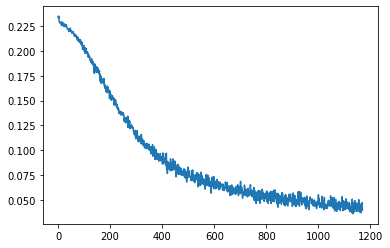

In [15]:
ann = ANN(layers=[X[0].shape[0],20,16,10], epochs=30, batch_size=512, learning_rate=0.01, activation=ReLU)
costs = ann.fit(X=X_norm, Y=Y)
print(f"Final test Accuracy: {Math.accuracy(Y_test, ann.predict(X_test_norm)):.2f}")
print()
plt.plot(costs)
plt.show()

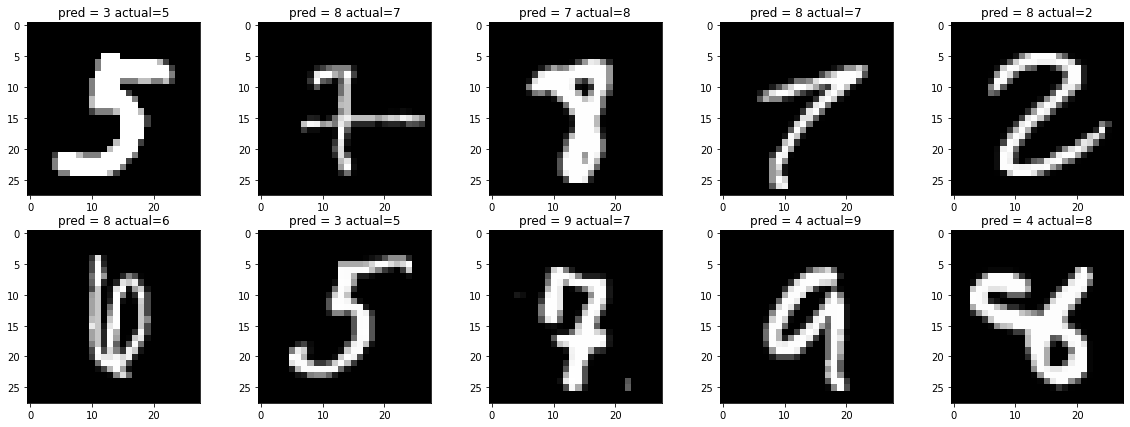

In [36]:
P = ann.predict(X_test_norm)
P_false = np.where(Y_test!=P)[0]
fig, axs = plt.subplots(2,5,figsize=(20,7))
for ax in axs.flat:
  index = np.random.choice(P_false)
  img = X_test[index].reshape((dims,dims))
  ax.set_title(f"pred = {P[index]} actual={Y_test[index]}")
  ax.imshow(img, cmap='gray', vmin=0, vmax=255)

((1118,), (9999,))